<a href="https://colab.research.google.com/github/apeking21/iit-taxifare/blob/main/Taxi%20Fare%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETL: Data Reading, Preprocessing and Loading
* #### In cell 1, the data is loaded and preprocessed using the preprocess() method, which takes in a DataFrame and does the relevant cleansing and transformation.
* #### The method is then called and used on the DataFrames obtained from reading train.csv and test.csv, and the output is saved into the relevant DataFrame variables.
* #### The training set is also divided further in a 80:20 split to obtain a validation set, so as to facilitate easy validation of the model's performance.

In [ ]:
# only libraries allowed are:
# Scikit-learn, XGBoost, Imblearn, NumPy
# Pandas, SciPy, Pickle, regex
# Seaborn, Matplotlib, Lightgbm

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

XYTrain = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
XTest = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv') # naturally, there is no Y in the testing set

def preprocess(df):
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).abs().dt.total_seconds()

    df['passenger_count'].fillna(df['passenger_count'].mode()[0], inplace=True)
    df['payment_type'].replace('unknown', 'Credit Card', inplace = True)
    df['RatecodeID'].fillna(df['RatecodeID'].mode()[0], inplace=True)
    df['congestion_surcharge'].fillna(0, inplace=True)
    df['store_and_fwd_flag'].fillna('N',inplace=True)
    df['Airport_fee'].fillna(0, inplace=True)

    df = pd.get_dummies(df, columns=['store_and_fwd_flag'], prefix=['store_and_fwd_flag'])
    df = pd.get_dummies(df, columns=['payment_type'], prefix=['payment_type'])

    df['improvement_surcharge'] = df['improvement_surcharge'].abs()
    df['congestion_surcharge'] = df['congestion_surcharge'].abs()
    df['tolls_amount'] = df['tolls_amount'].abs()
    df['Airport_fee'] = df['Airport_fee'].abs()
    df['extra'] = df['extra'].abs()

    #df = df.drop(columns=['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID'])

    try:
        df['total_amount'] = df['total_amount'].abs()
        Y = df['total_amount']
        df = df.drop(columns=['total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime'])

        numericalCols = [x for x in df.select_dtypes(include = 'number').columns.to_list() if 'ID' not in x]
        df[numericalCols] = MinMaxScaler().fit_transform(df[numericalCols])

        return train_test_split(df, Y, test_size=0.2, random_state=42)
    except:
        df = df.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])

        numericalCols = [x for x in df.select_dtypes(include = 'number').columns.to_list() if 'ID' not in x]
        df[numericalCols] = MinMaxScaler().fit_transform(df[numericalCols])

        return df

XTest = preprocess(XTest)
XTrain, XVal, YTrain, YVal = preprocess(XYTrain)

best_models = {}

## Preparing, Training and Tuning Baseline LR Model with CV
* #### Cell 2 contains the first model that was run to establish a baseline, and also to find the optimal degree for the *PolynomialFeatures* transformer.
* #### With the initial run, an *R2* score of *~0.878* was established against the validation set (a random 20% sample of *train.csv*)

In [ ]:
model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

param_grid = {
    'poly__degree': [2, 3],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(XTrain, YTrain)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

from sklearn.metrics import r2_score
YPred = best_model.predict(XVal)
print(f'R2 score: {r2_score(YPred, YVal)}')
print(f'Best params: {best_params}')

## Preparing, Training and Tuning Advanced Models using GridSearchCV
* #### Cell 3 contains the code where all the advanced and more complex models are applied on the preprocessed data.
* #### Each model was run individually to obtain the best parameters and R2 score on the validation set.

In [ ]:
regressors = {
    #'LR': (LinearRegression(), {}),
    #'KNN': (KNeighborsRegressor(), {'regressor__n_neighbors': [3, 5, 7]}),
    #'SVM': (SVR(), {'regressor__C': [0.1, 1.0], 'regressor__kernel': ['linear', 'rbf']}),
    'CART': (DecisionTreeRegressor(), {'regressor__max_depth': [None, 5, 10, 20]}),
    #'Bagging': (BaggingRegressor(base_estimator=DecisionTreeRegressor()), {'regressor__n_estimators': [10, 50, 100]}),
    #'Boosting': (AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), {'regressor__n_estimators': [10, 50, 100], 'regressor__learning_rate': [0.1, 1.0]}),
    #'MLP': (MLPRegressor(), {'regressor__hidden_layer_sizes': [(50, 50), (100, 100), (100, 100, 100)]}),
}

for regressor_name, (regressor, param_grid) in regressors.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('regressor', regressor)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(XTrain, YTrain)

    best_models[regressor_name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_
    }

    YPred = grid_search.best_estimator_.predict(XVal)
    print(f'{regressor_name}\tmodel trained with an R-squared score of {r2_score(YPred, YVal):.4f} on the validation set.')

### NOTE: training was extremely slow on Kaggle, hence the training was split between Kaggle, Colab and my personal PC. The R2 scores for each best model against the validation set are as follows:
### 1. Linear Regression:   **0.8782**
### 2. K-Nearest Neighbors: **0.6802**
### 3. CART:               ***0.9373*** (winner so far)
### 4. MLPRegressor:        **0.9194** (with a 50x50 hidden layer size)
### 5. BaggingRegressor:    **still running**
### 6. AdaBoostRegressor:   **still running**
### 6. SVR:                 **-0.1414**

.
.
.

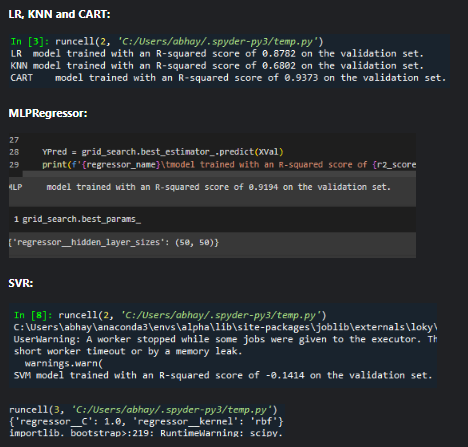

In [ ]:
for regressor_name, results in best_models.items():
    YPred = results["model"].predict(XVal)
    print(f'{regressor_name}\t: R-squared score on validation set = {r2_score(YPred, YVal):.4f}')

## Using Best Model
* #### As seen earlier, the CART model fared the best among the models run. Therefore, we will use it to produce the predictions.

In [ ]:
YPred = best_models['CART']['model'].predict(XTest)
OUTdf = pd.DataFrame()
OUTdf['ID'], OUTdf['total_amount'] = [x for x in range(1, XTest.shape[0]+1)], YPred

OUTdf.to_csv('submission.csv', index = False)